In [ ]:
!nvidia-smi

Sat Oct 11 08:03:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Oct 11 08:03 .
drwxr-xr-x 1 root root      4096 Oct 11 08:03 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


In [ ]:
%cd {HOME}/yolov9

/content/yolov9


In [ ]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("arvind-kumar-wjygd").project("anpr2-syxl7")
version = project.version(8)
dataset = version.download("yolov9")


visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ANPR2-8 in yolov9:: 100%|██████████| 626/626 [00:00<00:00, 8956.81it/s]


## Train Custom Model

In [ ]:
import yaml

data_yaml = {
    'train': '/content/yolov9/ANPR2-8/train/images',
    'val': '/content/yolov9/ANPR2-8/valid/images',  # or 'val' folder
    'nc': 1,  # Update with your number of classes
    'names': ['license_plate']  # Update with your class names
}

# Save corrected data.yaml
with open('/content/yolov9/ANPR2-8/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("Updated data.yaml saved!")

Updated data.yaml saved!


In [1]:
import re

# Files that might need patching
files_to_patch = [
    '/content/yolov9/train.py',
    '/content/yolov9/val.py',
    '/content/yolov9/detect.py',
    '/content/yolov9/utils/torch_utils.py'
]

def patch_torch_load(file_path):
    try:
        with open(file_path, 'r') as f:
            content = f.read()

        # Pattern to find torch.load without weights_only parameter
        pattern = r"torch\.load\(([^)]+)\)(?!\s*,\s*weights_only)"

        # Check if there are matches
        if re.search(pattern, content):
            # Replace with weights_only=False
            new_content = re.sub(
                r"torch\.load\(([^)]+)\)",
                r"torch.load(\1, weights_only=False)",
                content
            )

            with open(file_path, 'w') as f:
                f.write(new_content)

            print(f" Patched: {file_path}")
            return True
        else:
            print(f"  No changes needed: {file_path}")
            return False
    except FileNotFoundError:
        print(f"  File not found: {file_path}")
        return False
    except Exception as e:
        print(f" Error patching {file_path}: {e}")
        return False

# Patch all files
print("Patching YOLOv9 files for PyTorch 2.6+ compatibility...\n")
for file in files_to_patch:
    patch_torch_load(file)

print("\n Patching complete! You can now run training.")

Patching YOLOv9 files for PyTorch 2.6+ compatibility...

  File not found: /content/yolov9/train.py
  File not found: /content/yolov9/val.py
  File not found: /content/yolov9/detect.py
  File not found: /content/yolov9/utils/torch_utils.py

 Patching complete! You can now run training.


In [3]:
# Fix ONLY torch.load - nothing else
import re
import os

files = {
    '/content/yolov9/train.py': True,
    '/content/yolov9/val.py': True,
    '/content/yolov9/utils/general.py': True,
    '/content/yolov9/models/experimental.py': True,
}

for filepath in files:
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            content = f.read()

        # Simple replacement - if weights_only not there, add it
        if 'torch.load' in content and 'weights_only=False' not in content:
            content = content.replace(
                'torch.load(',
                'torch.load('
            ).replace(
                "map_location='cpu')",
                "map_location='cpu', weights_only=False)"
            ).replace(
                "map_location=torch.device('cpu'))",
                "map_location=torch.device('cpu'), weights_only=False)"
            ).replace(
                "map_location='cpu')  #",
                "map_location='cpu', weights_only=False)  #"
            )

            with open(filepath, 'w') as f:
                f.write(content)
            print(f" {filepath}")

print("\n All done  ")


 All done  


In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2025-10-11 08:45:24.823278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760172324.871120   12064 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760172324.881232   12064 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760172324.913888   12064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760172324.913924   12064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760172324.913933   12064 computation_placer.cc:177] comput

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

events.out.tfevents.1760169896.b3d1ddf4997b.1003.0  labels.jpg	 weights
hyp.yaml					    opt.yaml
labels_correlogram.jpg				    results.csv


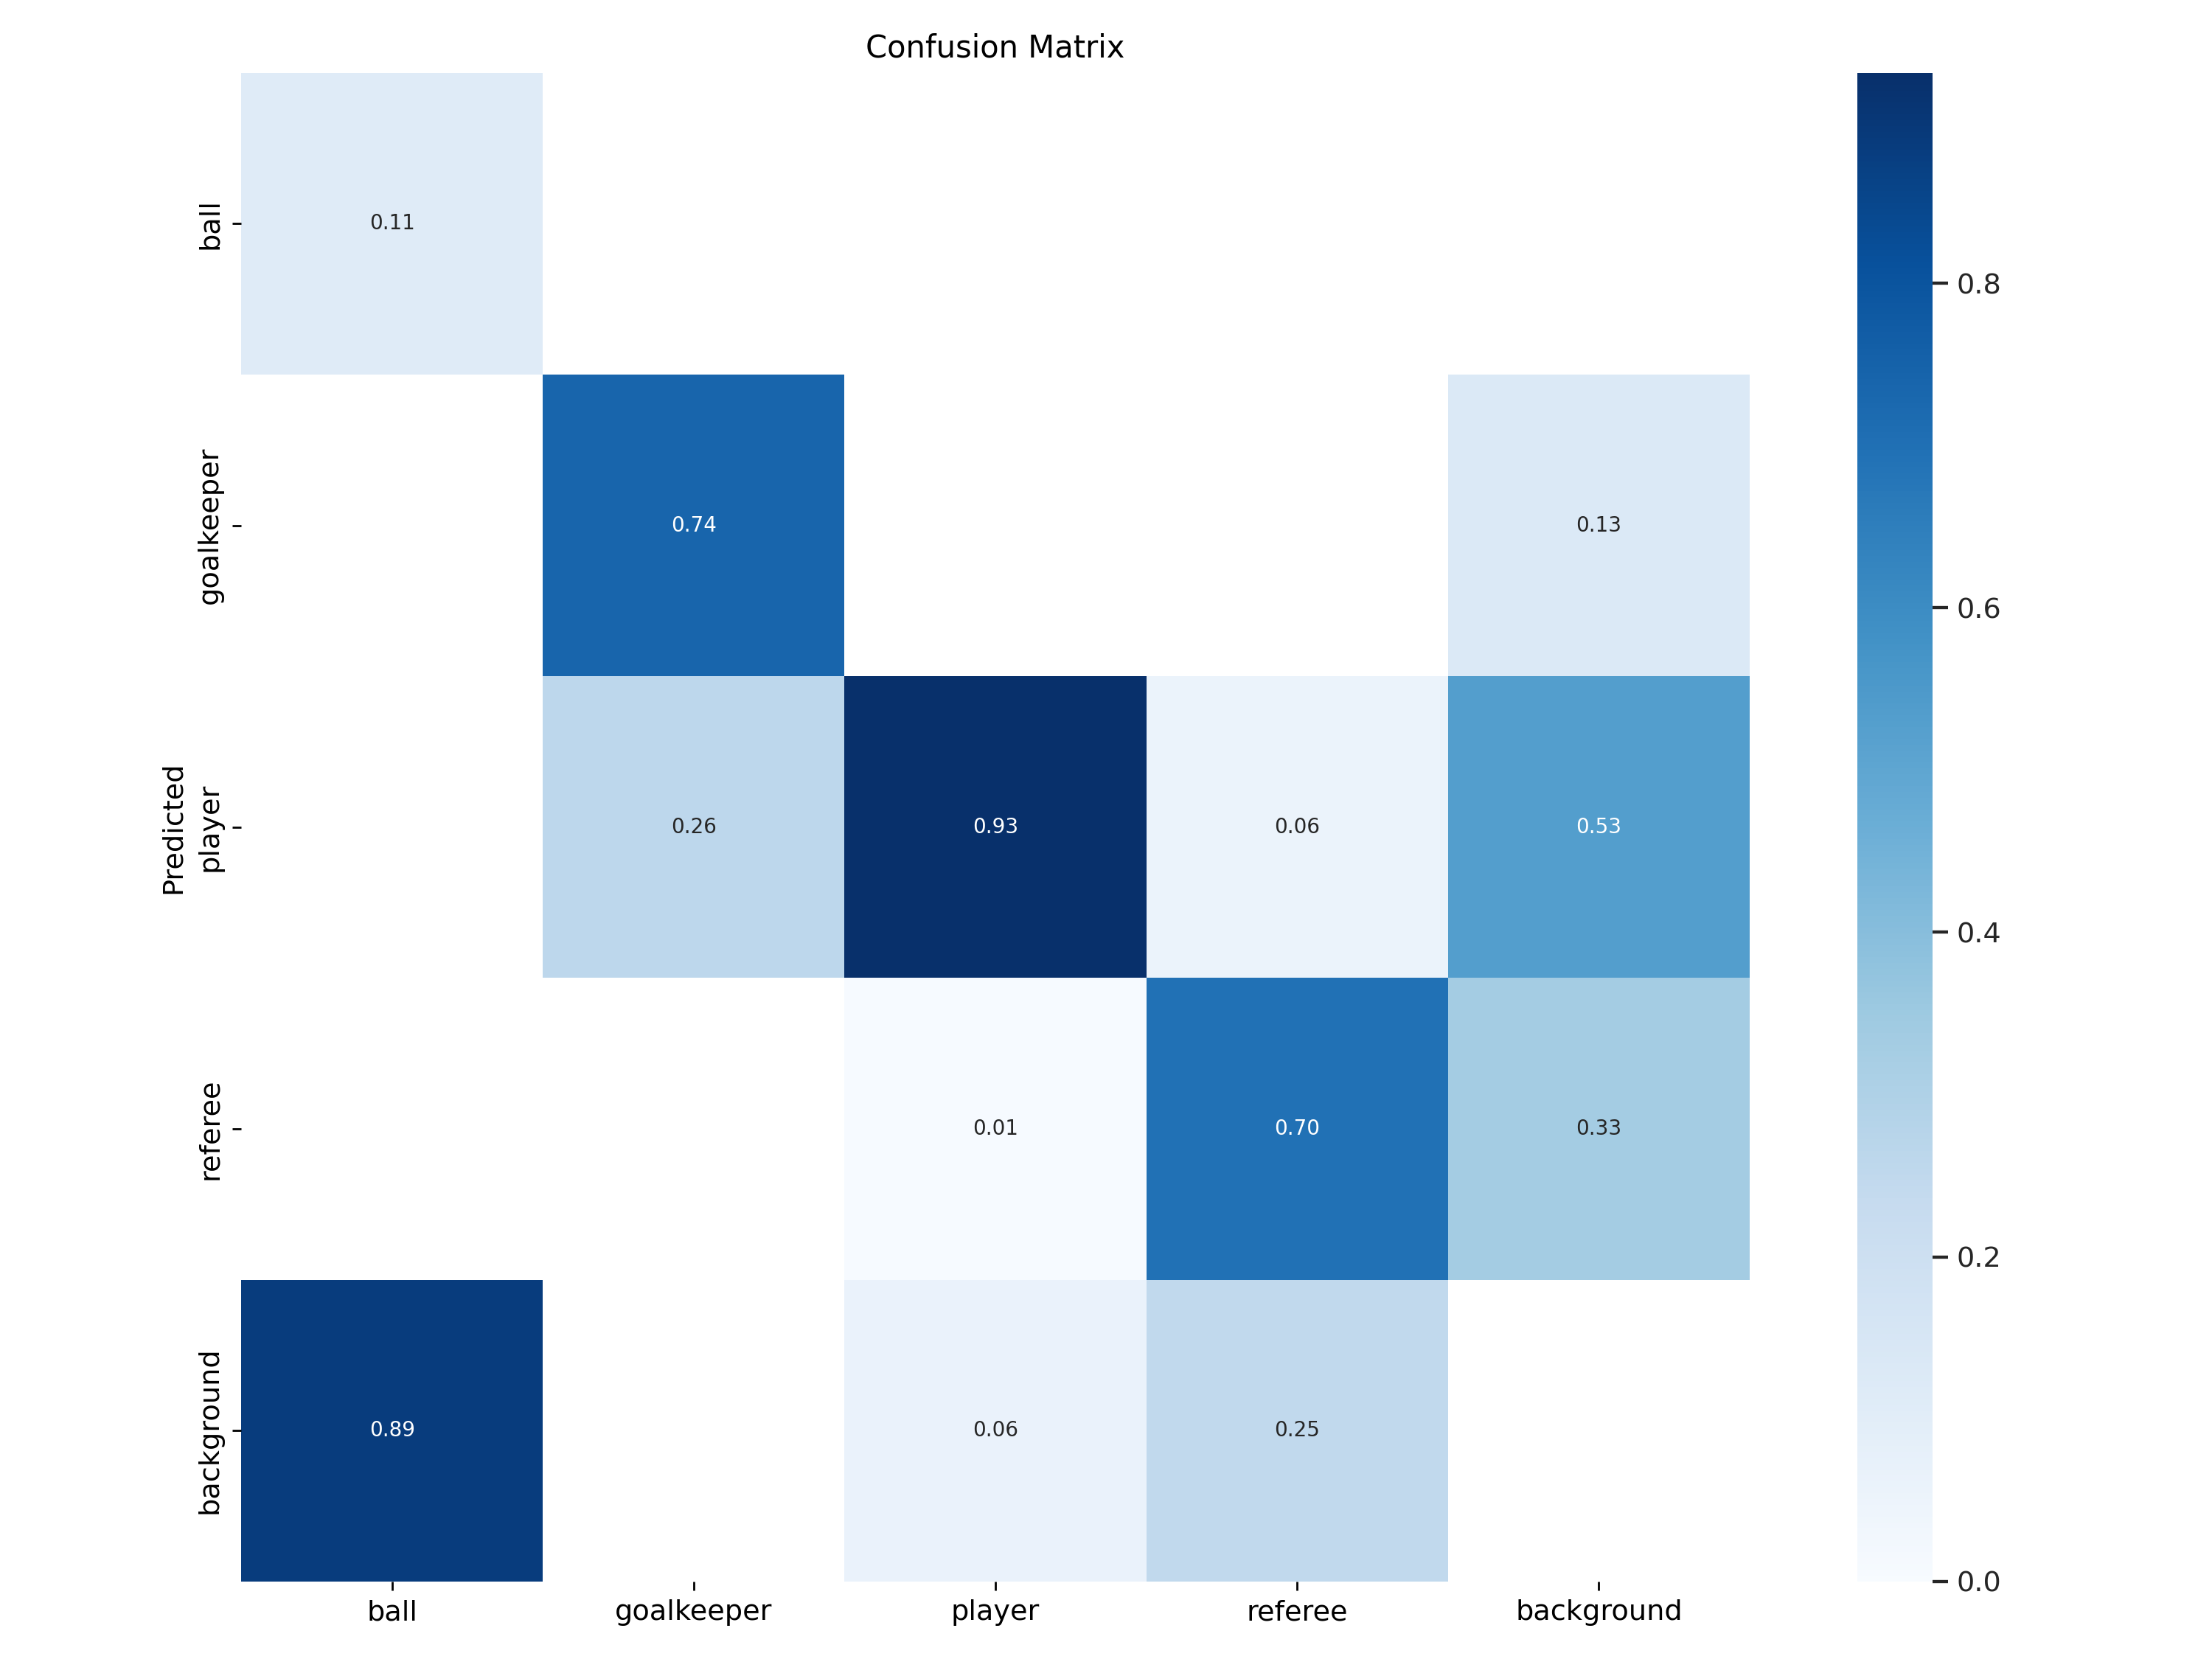

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000

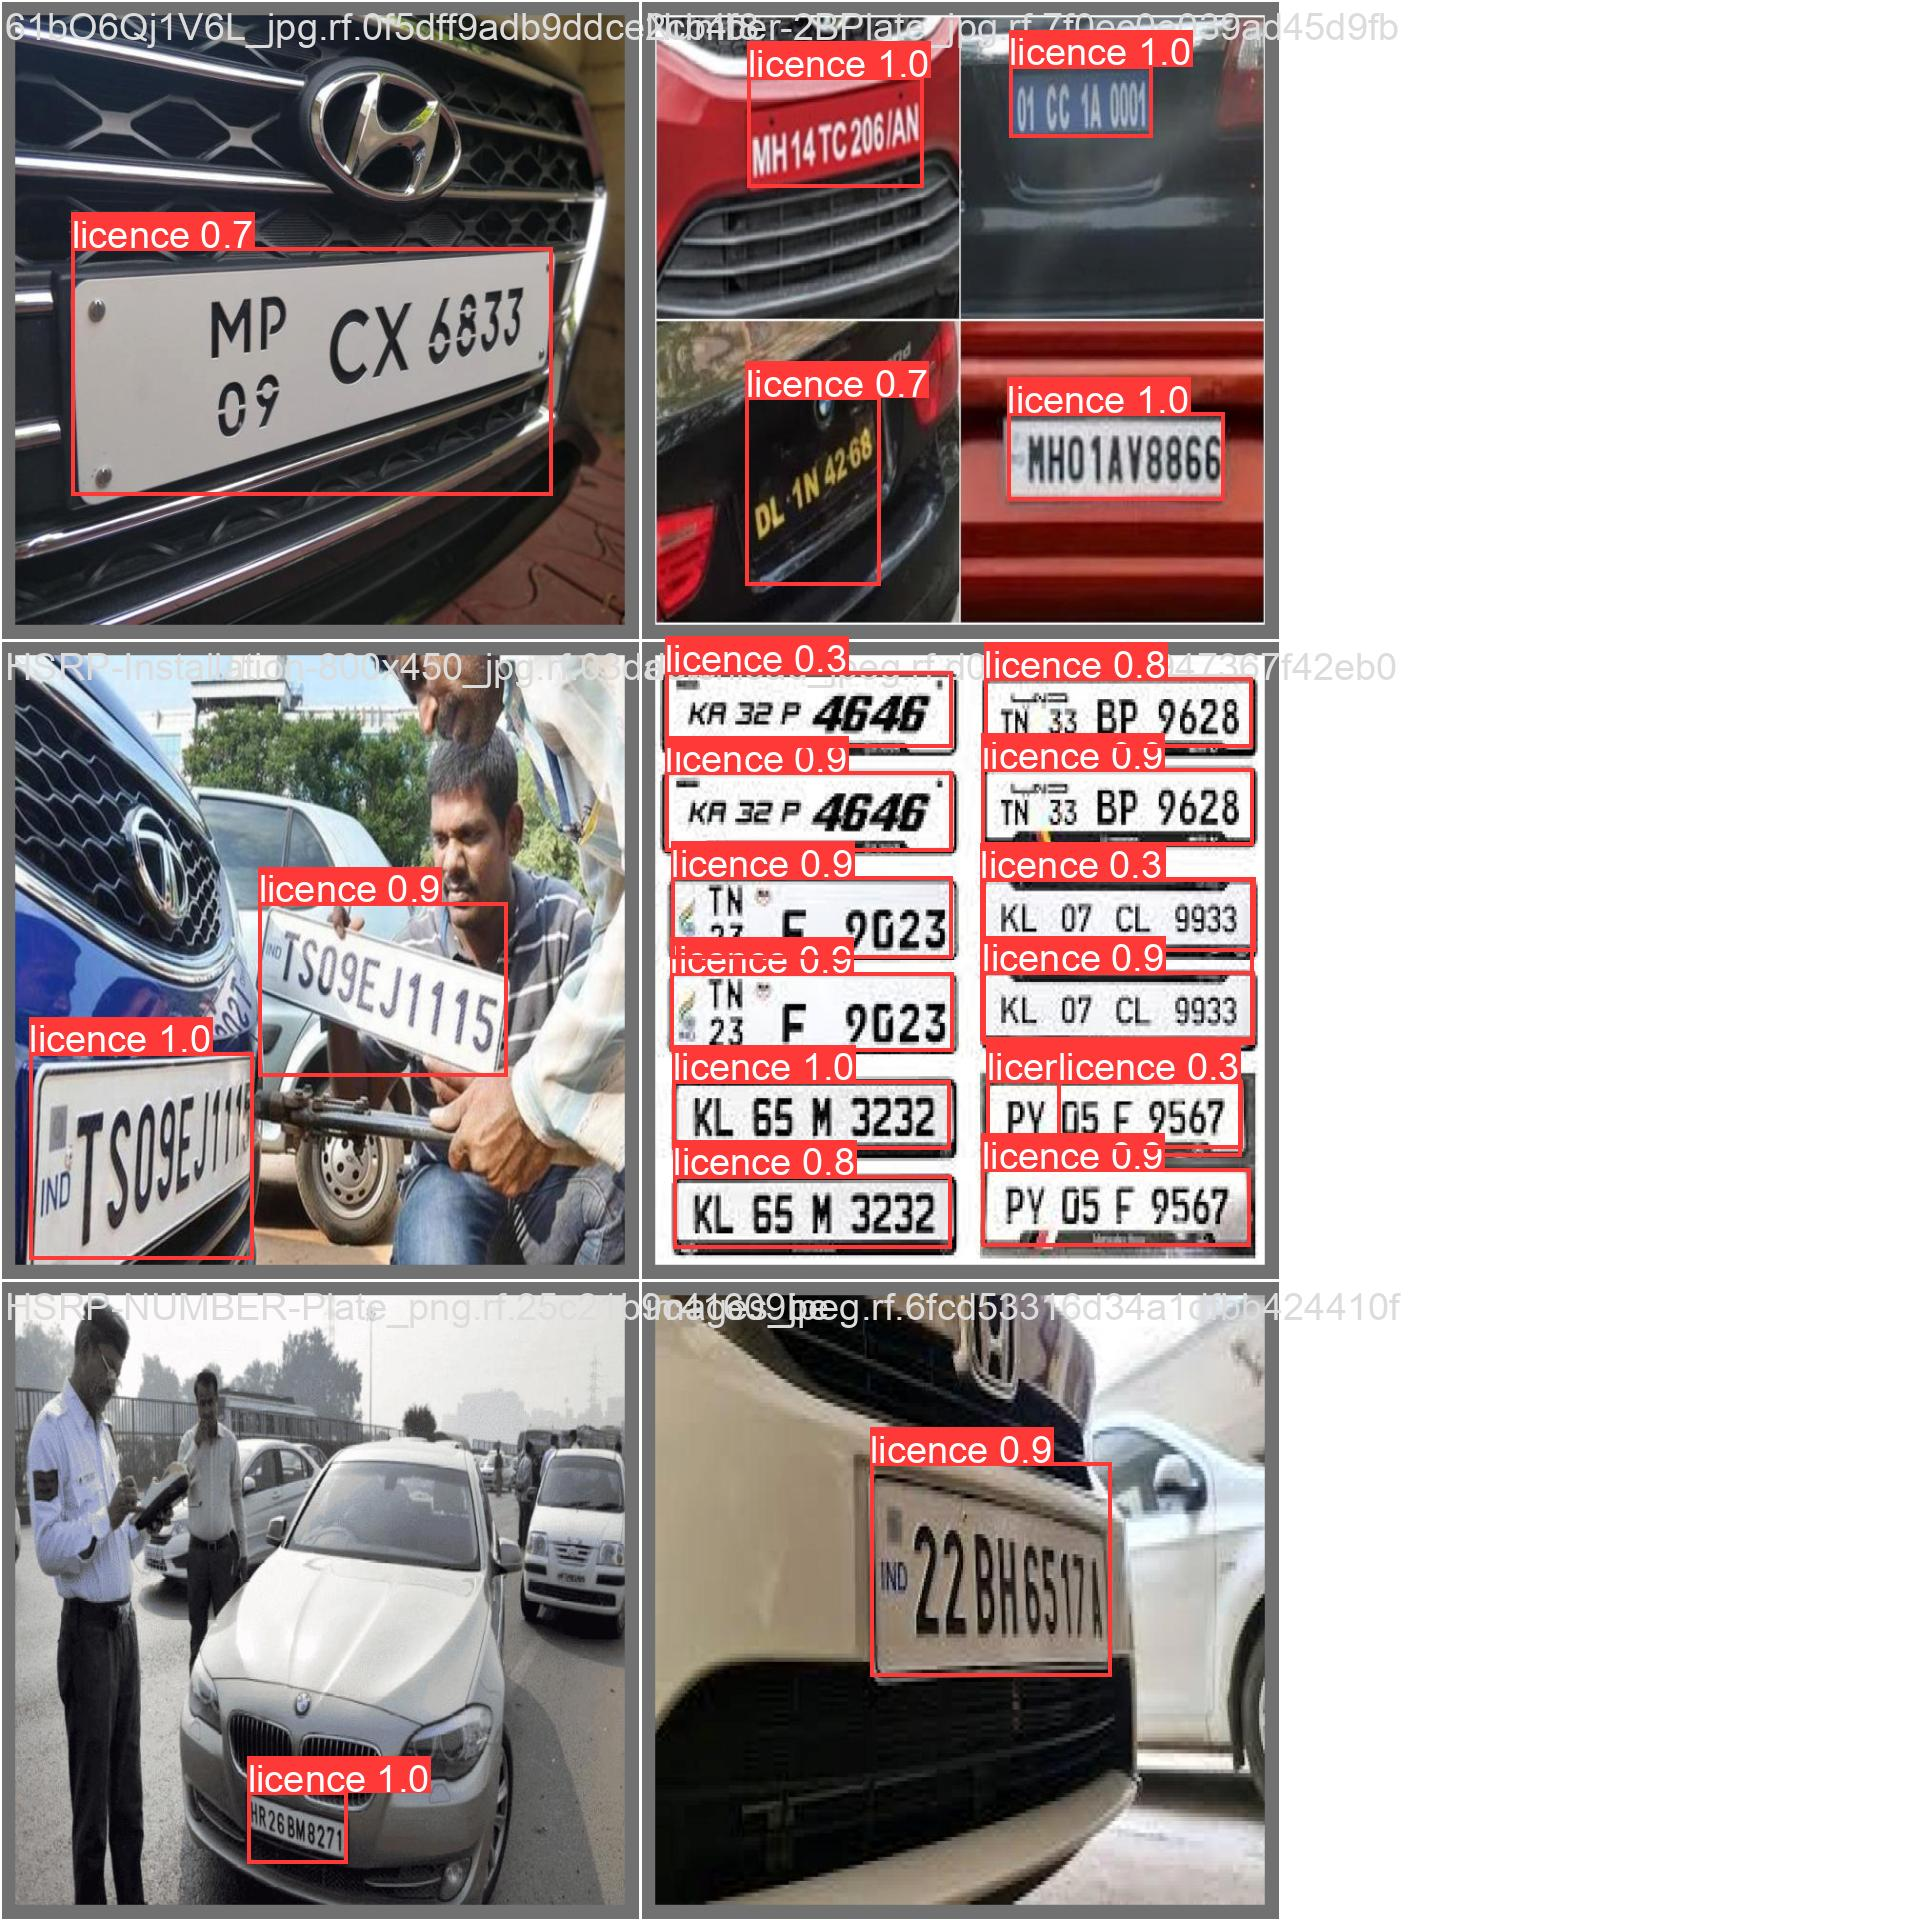

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [ ]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt

/content/yolov9
val: data=/content/yolov9/ANPR2-8/data.yaml, weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/ANPR2-8/valid/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.77it/s]
                   all          6         20      0.941      0.798      0.926      0.683
Speed: 0.8ms pre-process, 47.9ms inference, 13.7ms NMS per image at sha

## Inference with Custom Model

In [ ]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/yolov9/ANPR2-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
image 1/23 /content/yolov9/ANPR2-8/test/images/Cars411_png.rf.667117ea55d973fada6f86e842cf8000.jpg: 1280x1280 4 license_plates, 102.9ms
image 2/23 /content/yolov9/ANPR2-8/test/images/Cars412_png.rf.23df9b6cd177dad7b799613dcfa3ee18.jpg: 1280x1280 2 license_plates, 99.3ms
image 3/23 /content/yolov9/ANPR2-8/test/images

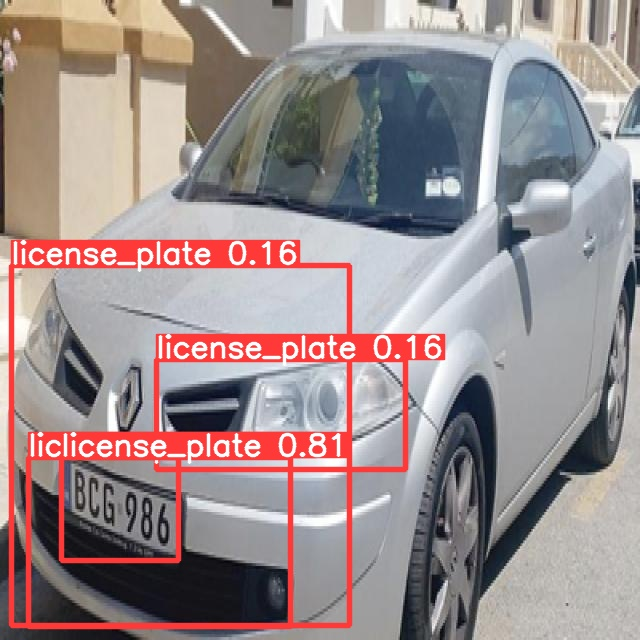

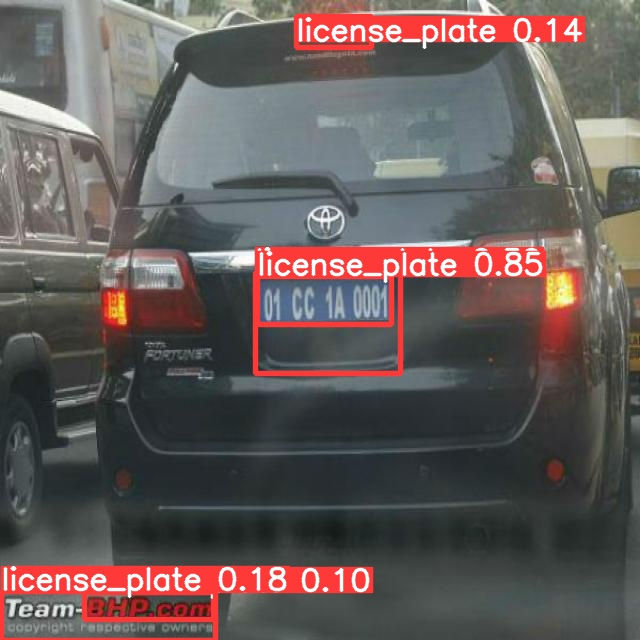

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

In [ ]:
# video

!python detect.py --conf 0.1 --device 0 --weights {HOME}/yolov9/runs/train/exp2/weights/best.pt --source car.mp4


detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=car.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
video 1/1 (1/631) /content/yolov9/car.mp4: 416x640 2 license_plates, 58.4ms
video 1/1 (2/631) /content/yolov9/car.mp4: 416x640 2 license_plates, 38.4ms
video 1/1 (3/631) /content/yolov9/car.mp4: 416x640 2 license_plates, 38.3ms
video 1/1 (4/631) /content/yolov9/car.mp4: 416x640 1 license_plate, 38.4ms
video 1/1 (5/631) /content/yolov9/car.mp4: 4

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 25.8 MB/s eta 0:00:00


In [ ]:
# video

!python anpr.py --conf 0.1 --device 0 --weights {HOME}/yolov9/runs/train/exp/weights/best.pt --source car.mp4


Progress: |██████████████████████████████████████████████████| 100.0% CompleteDownloading recognition model, please wait. This may take several minutes depending upon your network connection.
Progress: |██████████████████████████████████████████████████| 100.0% Completeanpr: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=car.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
video 1/1 (1/631) /content/yolov9/car.mp4: 416x640 2 license_plates, 63.1ms
vide